Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 158, 127, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 79, 63, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 77, 61, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 38, 30, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 36, 28, 128)       73856     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 18, 14, 128)      

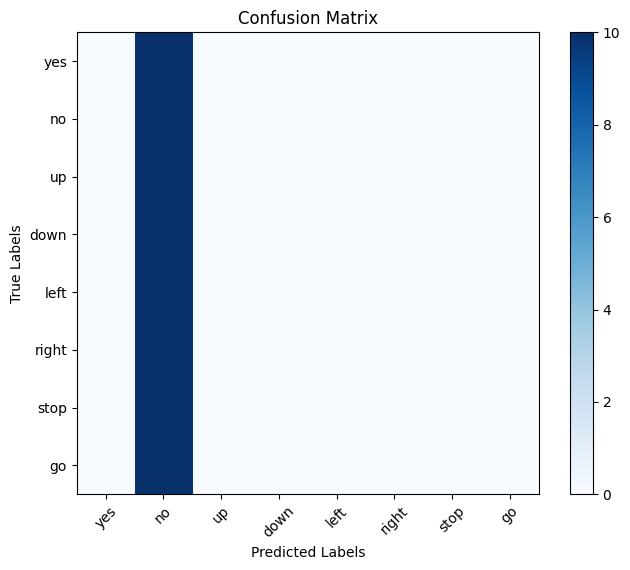

Classification Report:
              precision    recall  f1-score   support

         yes       0.00      0.00      0.00        10
          no       0.12      1.00      0.22        10
          up       0.00      0.00      0.00        10
        down       0.00      0.00      0.00        10
        left       0.00      0.00      0.00        10
       right       0.00      0.00      0.00        10
        stop       0.00      0.00      0.00        10
          go       0.00      0.00      0.00        10

    accuracy                           0.12        80
   macro avg       0.02      0.12      0.03        80
weighted avg       0.02      0.12      0.03        80



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [6]:
import os
import tensorflow as tf
import numpy as np
import urllib.request
import zipfile
import librosa.display
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report

# Function to extract audio features
def preprocess_audio(audio, max_length):
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32) / 32768.0  # Normalize to range [-1, 1]
    audio = tf.signal.stft(audio, frame_length=256, frame_step=128)
    audio = tf.abs(audio)
    # Pad or truncate to max_length
    audio = tf.pad(audio, [[0, max_length - tf.shape(audio)[0]], [0, 0]])
    return audio

# Function to extract audio features
def preprocess_audio(audio, max_length):
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32) / 32768.0  # Normalize to range [-1, 1]
    audio = tf.signal.stft(audio, frame_length=256, frame_step=128)
    audio = tf.abs(audio)
    # Pad or truncate to max_length
    audio = tf.pad(audio, [[0, max_length - tf.shape(audio)[0]], [0, 0]])
    # Add a channel axis
    audio = tf.expand_dims(audio, axis=-1)
    return audio

# Build the ASR model
def build_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Generate a report
def generate_report(model, X_test, y_test, classes):
    # Make predictions
    predictions = model.predict(X_test)
    predicted_labels = np.argmax(predictions, axis=1)

    # Compute confusion matrix
    confusion_matrix = tf.math.confusion_matrix(y_test, predicted_labels)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    plt.imshow(confusion_matrix, cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    plt.colorbar()
    plt.show()

    # Display classification report
    print("Classification Report:")
    print(classification_report(y_test, predicted_labels, target_names=classes))

def main():
    # Download and extract the dataset
    data_url = "http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip"
    data_path = "mini_speech_commands.zip"
    urllib.request.urlretrieve(data_url, data_path)
    with zipfile.ZipFile(data_path, "r") as zip_ref:
        zip_ref.extractall("data/")

    # Define classes (labels)
    classes = ['yes', 'no', 'up', 'down', 'left', 'right', 'stop', 'go']

    # Load and preprocess the dataset
    data_dir = "data/mini_speech_commands"
    max_length = 160  # Maximum length of audio features
    X_train, y_train = process_data(data_dir, classes, num_samples_per_class=100, max_length=max_length)
    X_test, y_test = process_data(data_dir, classes, num_samples_per_class=10, max_length=max_length)

    # Build the model
    input_shape = X_train[0].shape
    num_classes = len(classes)
    model = build_model(input_shape, num_classes)
    model.summary()

    # Compile the model
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Train the model
    model.fit(X_train, y_train, epochs=10, batch_size=32)

    # Generate report
    generate_report(model, X_test, y_test, classes)

if __name__ == "__main__":
    main()
